<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
## ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_KaggleCompetition

#@title Current Date
Today = '2021-10-15' #@param {type:"date"}


#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "1" #@param {type:"string"}
Student_ID&Name = "20156952 Dáire Campbell" #@param {type:"string"}
Student_ID&Name = "20151586 Carlos Amaral" #@param {type:"string"}
Student_ID&Name = "9022724 Nigel Portley" #@param {type:"string"}
Student_ID&Name = "20172257 Stephen Quirke" #@param {type:"string"}
Student_ID&Name = "20214537 Tom Keane" #@param {type:"string"}
#@markdown ---

In [1]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Final" #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer



In [7]:
# Modules for visuals
# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

# XGBoost for feature selection
from xgboost import XGBClassifier
from xgboost import plot_importance

# Improve the Jupyter Notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Improve pandas dataframe results
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [8]:
import spacy

In [9]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Get the dataset: train, test, and true price.

In [11]:
# The code runs quicker locally, but
# I have a Colab version for distribution.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Masters_in_AI/et5003/etivity2/'
    print("Running in Colab.")
except Exception as e:
    print("Running locally.")
    Path = "./"

Running locally.


In [12]:
# Load data
house_train = pd.read_csv(Path+"house_train.csv")
house_train = house_train[house_train["price"].notna()]
house_train = house_train.rename(columns = {"price": "Expected"})

house_test = pd.read_csv(Path+"house_test.csv")
true_price = pd.read_csv(Path+"true_price.csv")
# Add house value to the dataset

house_test = house_test.merge(
    true_price,
    left_on = "ad_id",
    right_on = "Id",
    how = "inner")

<AxesSubplot:xlabel='Expected', ylabel='Density'>

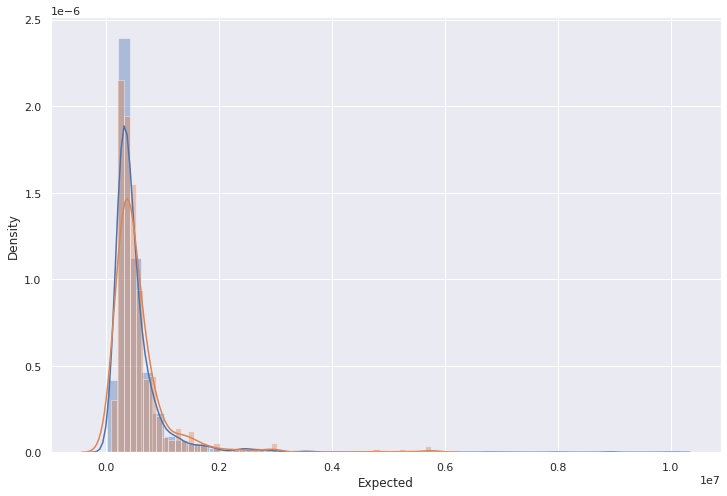

In [13]:
# Confirm the price distributions are the similiar
# between the reaining and test datasets.
sns.distplot(house_train["Expected"])
sns.distplot(house_test["Expected"])

In [119]:
X_train,X_test,y_train,y_test = house_train.drop("Expected", axis = 1), house_test.drop("Expected", axis = 1), house_train["Expected"], house_test["Expected"]

In [14]:
# Combine Train and Test data sets
X_ = pd.concat([house_train, house_test], ignore_index = True)

X = X_.drop("Expected", axis = 1)
y = X_["Expected"]

## Training & Test Data

In [75]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

## Clean the dataset: remove nan's and possible outliers.

In [120]:
# Map from area to Dublin postcode
# This will reduce number of features in areas
area_to_postcode = {
    'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
    'Grand Canal Dock':'Dublin 2',
    'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
    'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
    'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
    'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
    'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
    'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
    'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
    'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
    'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
    'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
    'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
    'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
    'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
    'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
    'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
    'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
    'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
    'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
    'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
    'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
    'Donabate':'Co. Fingal','Swords':'Co. Fingal','Portmarnock':'Co. Fingal','Kinsealy':'Co. Fingal','Balgriffin':'Co. Fingal','Garristown':'Co. Fingal','Naul':'Co. Fingal','Skerries':'Co. Fingal','Rush':'Co. Fingal','Lusk':'Co. Fingal','Balbriggan':'Co. Fingal','Loughshinny':'Co. Fingal','Ballybough':'Co. Fingal',
    'Blackrock':'Co. Dun Laoghaire-Rathdown','Dun Laoghaire':'Co. Dun Laoghaire-Rathdown','Glenageary':'Co. Dun Laoghaire-Rathdown',
    'Monkstown':'Co. Dun Laoghaire-Rathdown','Booterstown':'Co. Dun Laoghaire-Rathdown','Sandycove':'Co. Dun Laoghaire-Rathdown',
    'Rathmichael':'Co. Dun Laoghaire-Rathdown','Mount Merrion':'Co. Dun Laoghaire-Rathdown','Ballybrack':'Co. Dun Laoghaire-Rathdown','Sallynoggin':'Co. Dun Laoghaire-Rathdown',
    'Kilmacud':'Co. Dun Laoghaire-Rathdown','Dalkey':'Co. Dun Laoghaire-Rathdown','Killiney':'Co. Dun Laoghaire-Rathdown','Loughlinstown':'Co. Dun Laoghaire-Rathdown',
    }

In [121]:
# Map from Dublin postcode to a flag 
# if its southside or northside
postcode_north_south = {
    "Co. Fingal":False,
    "Co. Dun Laoghaire-Rathdown":True,
    "Dublin 4":True,
    "Dublin 18":True,
    "Dublin 15":False,
    "Dublin 6":True,
    "Dublin 6w":True,
    "Dublin 3":False,
    "Dublin 16":True,
    "Dublin 13":False,
    "Dublin 9":False,
    "Dublin 7":False,
    "Dublin 24":True,
    "Dublin 20":True,
    "Dublin 5":False,
    "Dublin 12":True,
    "Dublin 8":True,
    "Dublin 14":True,
    "Dublin 22":True,
    "Dublin 17":False,
    "Dublin 11":False,
    "Dublin 2":True,
    "Dublin 10":True,
    "Dublin 1":False
}

In [122]:
def pre_processing_features(df_, train_data):
    """
    Function to preprocess features.
    This includes One-Hot Encoding and 
    encoding columns.

    Creating a function as will be applied to both 
    Training and Testing data.

    ::param df: (pandas dataframe)
    ::param data: (pandas dataframe)
        Data to use to fill empty values and to encode
        Using Training data to not bias results
    ::param ber_dict: (dict)
    ::return: (pandas dataframe)
    """
    df = df_.copy(deep = True)
    # Creating a mapping from ber letter to number
    # ber classification is ordinal
    ber_numbers = sorted(train_data.ber_classification.fillna(
        train_data.ber_classification.mode()[0]).unique())
    ber_dict = dict(zip(ber_numbers, range(len(ber_numbers))))
    
    # Encoding
    # Fill NaN values with mode
    df["ber_classification"] = df["ber_classification"]\
        .map(ber_dict)\
        .fillna(ber_dict[df.ber_classification.mode()[0]])
    
    return df


def create_new_features(dataframe_, train_data):
    """
    Functions to parse out new feaures from the dataframe.
    These are:
        - Alarm
        - Gas Fired Central Heating
        - Oil Fired Central Heating
        - Parking
        - Wheelchair Access
        - Wired for Cable Television

    ::param dataframe: (pandas DataFrame)
    ::return: (pandas DataFrame)
    """
    dataframe = dataframe_.copy(deep = True)
    print(
        "Percentage Facility populated: ",
        sum(dataframe["facility"].notna())*100/len(dataframe), "%")
    
    for fac in [
        "Alarm",
        "Gas Fired Central Heating",
        "Oil Fired Central Heating",
        "Parking",
        "Wheelchair Access",
        "Wired for Cable Television"]:
        dataframe[fac.lower().replace(" ", "_")] = dataframe["facility"].str.contains(fac).fillna(False)
    
    dataframe["postcode"] = dataframe["area"].map(area_to_postcode)
    
    postcode = pd.get_dummies(dataframe["postcode"])
    dataframe[postcode.columns] = postcode
    
    dataframe["postcode_north_south"] = dataframe["postcode"].map(postcode_north_south)

    # Via Nigel Portley
    dataframe["property_type"] = dataframe["property_type"].map({
        "apartment": 1,
        "bungalow": 5,
        "detached": 9,
        "duplex": 2,
        "end-of-terrace": 6,
        "semi-detached": 8,
        "site": 3,
        "studio": 0,
        "terraced": 4,
        "townhouse": 7
    })

    dataframe = pre_processing_features(dataframe, train_data)
    
    return dataframe

In [123]:
# Apply preprocessing
# Using X_train for the One Hot Encoding as we dont wasnt to contaminate the Test data
X_train_ = create_new_features(X_train, X_train.copy(deep = True))
X_test_ = create_new_features(X_test, X_train.copy(deep = True))

Percentage Facility populated:  32.84923928077455 %
Percentage Facility populated:  37.8 %


In [124]:
# Add columns to test data from training data
# These could be missing from One Hot Encoding etc

for column in list(
    set(X_train_.columns) - set(X_test_.columns)):
    print(column)
    X_test_[column] = 0

In [125]:
print(f"Origional length of training data: {len(X_train_)}")
print(f"Origional length of test data: {len(X_test_)}")

X_train_ = X_train_[X_train_["surface"] < 4000]
print(f"Length of X_train_ is now {len(X_train_)}, after removing surface outliers.")
X_test_ = X_test_[X_test_["surface"] < 4000]
print(f"Length of X_test_ is now {len(X_test_)}, after removing surface outliers.")

X_train_ = X_train_[X_train_["beds"] > 0]
print(f"Length of X_train_ is now {len(X_train_)}, after removing beds outliers.")
X_test_ = X_test_[X_test_["beds"] > 0]
print(f"Length of X_test_ is now {len(X_test_)}, after removing beds outliers.")

X_train_ = X_train_[X_train_["bathrooms"] >0]
print(f"Length of X_train_ is now {len(X_train_)}, after removing bathroom outliers.")
X_test_ = X_test_[X_test_["bathrooms"] >0]
print(f"Length of X_test_ is now {len(X_test_)}, after removing bathroom outliers.")

X_train_ = X_train_[X_train_["longitude"] < -6]
print(f"Length of X_train_ is now {len(X_train_)}, after removing longitude outliers.")
X_test_ = X_test_[X_test_["longitude"] < -6]
print(f"Length of X_test_ is now {len(X_test_)}, after removing longitude outliers.")

X_train_ = X_train_[X_train_["latitude"] > 53]
print(f"Length of X_train_ is now {len(X_train_)}, after removing latitude outliers.")
X_test_ = X_test_[X_test_["latitude"] > 53]
print(f"Length of X_test_ is now {len(X_test_)}, after removing latitude outliers.")


Origional length of training data: 2892
Origional length of test data: 500
Length of X_train_ is now 2388, after removing surface outliers.
Length of X_test_ is now 499, after removing surface outliers.
Length of X_train_ is now 2359, after removing beds outliers.
Length of X_test_ is now 490, after removing beds outliers.
Length of X_train_ is now 2346, after removing bathroom outliers.
Length of X_test_ is now 487, after removing bathroom outliers.
Length of X_train_ is now 2345, after removing longitude outliers.
Length of X_test_ is now 487, after removing longitude outliers.
Length of X_train_ is now 2345, after removing latitude outliers.
Length of X_test_ is now 487, after removing latitude outliers.


In [126]:
y_train = y_train[X_train_.index]
y_test = y_test[X_test_.index]

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Your comments, explanation, and references here.

In [127]:
desc_column = "description_block"
feat_column = "features"

In [128]:
nltk.download('stopwords')

swords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/daire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
X_train_ = X_train_.reset_index()
X_test_ = X_test_.reset_index()

In [130]:
for column in [desc_column, feat_column]:
    # tokenization
    tokenized_doc = X_train_[column].fillna("").apply(lambda x: x.split())
    
    # remove stop-words
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in swords])

    # de-tokenization
    detokenized_doc = []
    for i in range(len(X_train_)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
    X_train_[column+"_clean"] = detokenized_doc

    # tokenization
    tokenized_doc = X_test_[column].fillna("").apply(lambda x: x.split())
    
    # remove stop-words
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in swords])

    # de-tokenization
    detokenized_doc = []
    for i in range(len(X_test_)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
    X_test_[column+"_clean"] = detokenized_doc

In [131]:
vectoriser_desc = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)

vectoriser_desc = vectoriser_desc.fit(X_train_[desc_column+"_clean"])
tfidf_train_desc = vectoriser_desc.transform(X_train_[desc_column+"_clean"])
tfidf_test_desc = vectoriser_desc.transform(X_test_[desc_column+"_clean"])

tfidf_train_desc.shape, tfidf_test_desc.shape

((2345, 300), (487, 300))

In [132]:
vectoriser_desc = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)

vectoriser_desc = vectoriser_desc.fit(X_train_[feat_column+"_clean"])
tfidf_train_feat = vectoriser_desc.transform(X_train_[feat_column+"_clean"])
tfidf_test_feat = vectoriser_desc.transform(X_test_[feat_column+"_clean"])

tfidf_train_feat.shape, tfidf_test_feat.shape

((2345, 300), (487, 300))

### Combine TF-IDF data to training and test data

In [133]:
# Features to train model on
feature_cols = [
    'bathrooms',
    'beds',
    'ber_classification',
    'latitude',
    'longitude',
    "property_type",
    'alarm',
    'gas_fired_central_heating',
    'oil_fired_central_heating',
    'parking',
    'wheelchair_access',
    'wired_for_cable_television',
    'Co. Dun Laoghaire-Rathdown',
    'Co. Fingal',
    'Dublin 1',
    'Dublin 10',
    'Dublin 11',
    'Dublin 12',
    'Dublin 13',
    'Dublin 14',
    'Dublin 15',
    'Dublin 16',
    'Dublin 17',
    'Dublin 18',
    'Dublin 2',
    'Dublin 20',
    'Dublin 22',
    'Dublin 24',
    'Dublin 3',
    'Dublin 4',
    'Dublin 5',
    'Dublin 6',
    'Dublin 6w',
    'Dublin 7',
    'Dublin 8',
    'Dublin 9',
    #'postcode_north_south',
]

In [134]:
train_data = np.c_[X_train_[feature_cols].values, tfidf_train_desc.toarray(), tfidf_train_feat.toarray()]
test_data = np.c_[X_test_[feature_cols].values, tfidf_test_desc.toarray(), tfidf_test_feat.toarray()]

In [135]:
train_data.shape, test_data.shape

((2345, 636), (487, 636))

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

Your comments, explanation, and references here.

In [136]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

n = 6#test_data.shape[1]

xscaler = sc.fit(train_data[:, :n])
Xn_train = xscaler.transform(train_data[:, :n])
Xn_test = xscaler.transform(test_data[:, :n])

#ylog = np.log(ys_train.astype('float'))
ylog = np.log(y_train.astype('float').values.reshape(-1,1))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)
ylog = np.log(y_test.astype('float').values.reshape(-1,1))
yn_test = yscaler.transform(ylog)

ys_train = yn_train.astype(float)
ys_test = yn_test.astype(float)

### Base model

In [137]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    #like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,301.3


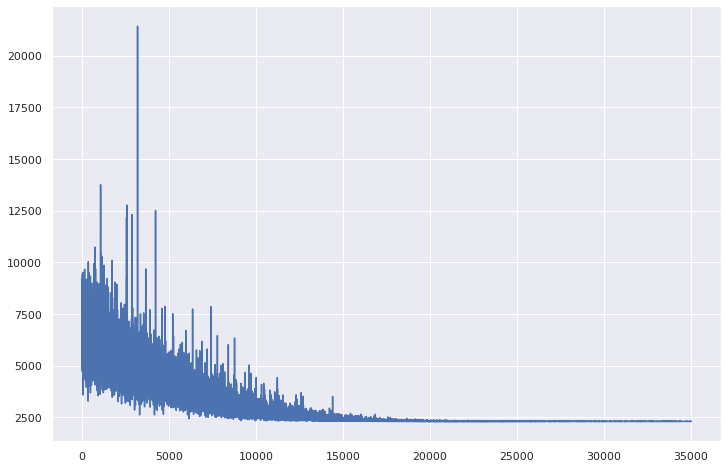

In [138]:
#number of iterations of the algorithms
iter = 35000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [139]:
# samples from the posterior
posterior = approximation.sample(5000)

In [140]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  207739.84133967976
MAPE =  0.271722136922466


### Peicewise Model

In [141]:
# Our data is very high dimensional, compared to its size, so Piecewise Regressio would work better on lower dimesnions

In [142]:
# Number of components
component = 4

### Cluster data

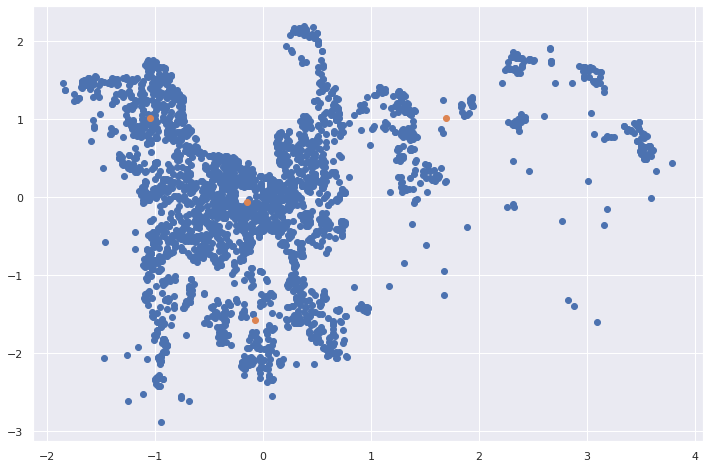

In [143]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

# Longitude and latitude
ind=[3, 4]


gmm = GaussianMixture(n_components=component)
# clustering by features 1, 2
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [144]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 1201, 1: 369, 2: 359, 3: 416}

In [145]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 258, 1: 80, 2: 84, 3: 65}

### Piecewise Model

In [146]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


In [147]:
# Create a dictiornary to store cluster components
# This will allow the code to run more dynamically, and I could add extra clusters trivially

# Cluster Data
cd = {}


Cluster 0 has size of 1201 rows.


Finished [100%]: Average Loss = 761.33


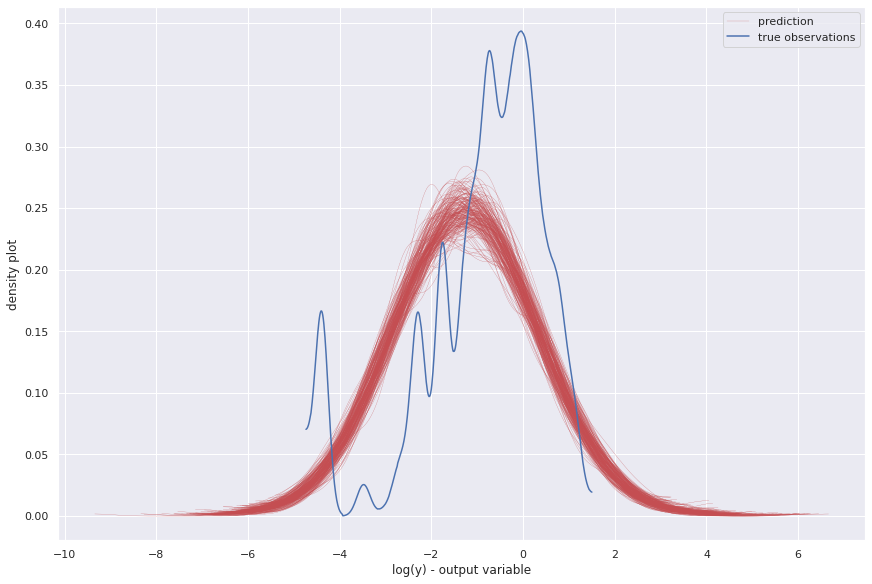

Cluster 1 has size of 369 rows.


Finished [100%]: Average Loss = 363.5


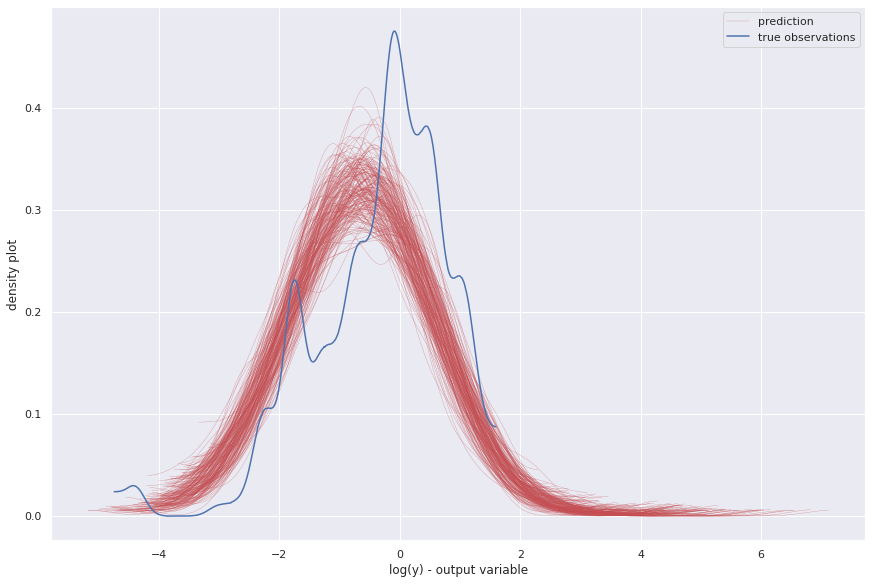

Cluster 2 has size of 359 rows.


Finished [100%]: Average Loss = 240.75


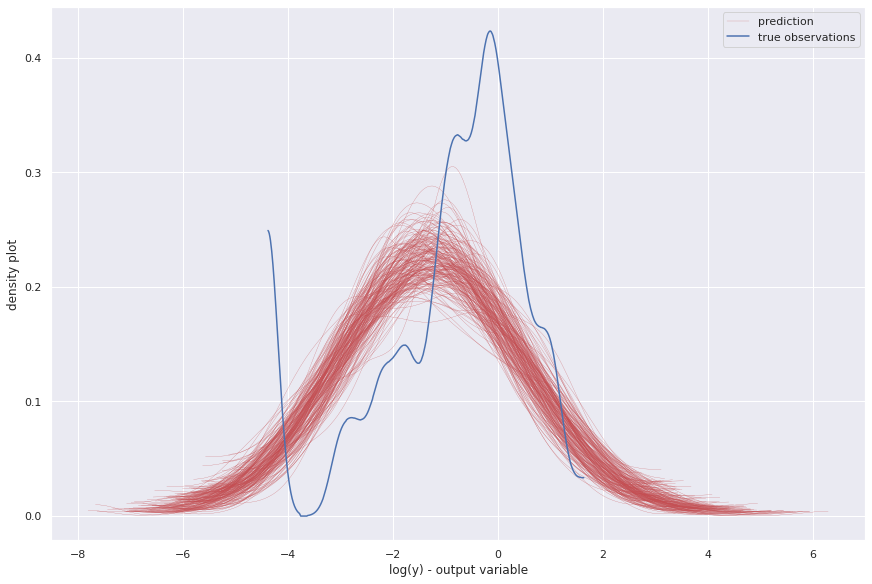

Cluster 3 has size of 416 rows.


Finished [100%]: Average Loss = 176.38


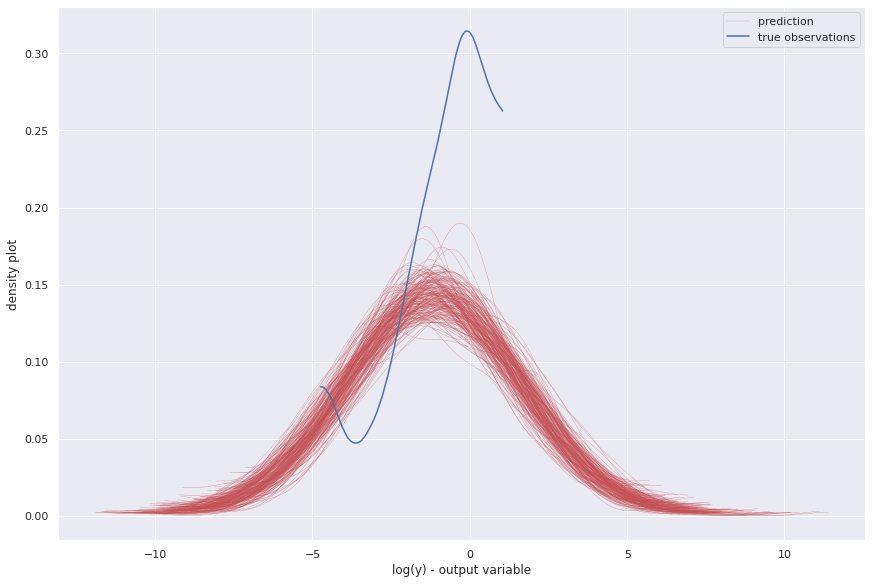

In [148]:
for j in range(component):
    cd_temp = {}
    cd_temp["Xn"] = Xn_train[clusters_train==j,:]
    cd_temp["Xtestn"] = Xn_test[clusters_test==j,:]

    cd_temp["ylog"] = np.log(ys_train.astype('float')[clusters_train==j,:])
    cd_temp["yscaler"] = StandardScaler().fit(cd_temp["ylog"])
    cd_temp["yn"] = cd_temp["yscaler"].transform(cd_temp["ylog"])
    print(f"Cluster {j} has size of {len(cd_temp['Xn'])} rows.")

    with pm.Model() as model_:
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=cd_temp["Xn"].shape[1])
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
        # linear regression relationship
        #linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, cd_temp["Xn"].T)
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=cd_temp["yn"][:,0])

    with model_:
        # iterations of the algorithm
        approximation = pm.fit(40000,method='advi')

    # samples from the posterior   
    cd_temp["posterior"] = approximation.sample(5000)

    #Simulation
    Ypred = cd_temp["yscaler"].inverse_transform(ppc(
        cd_temp["posterior"]['alpha'],
        cd_temp["posterior"] ['beta'],
        cd_temp["posterior"] ['sigma_n'],cd_temp["Xn"],  nsamples=200))

    for i in range(Ypred.shape[0]):
        az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
    #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
    #plt.xlim([0,10e7])
    az.plot_dist(cd_temp["ylog"],label='true observations');
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");
    plt.show()

    cd[j] = cd_temp


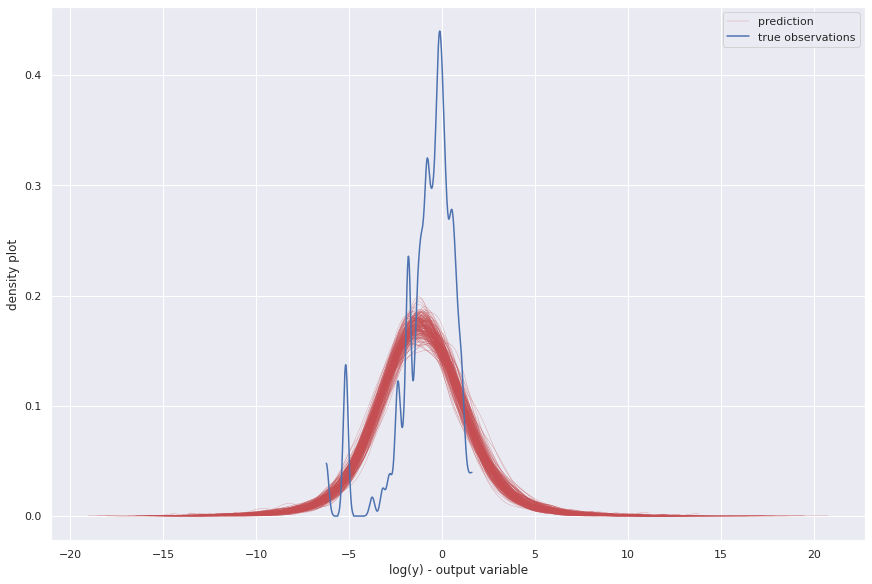

In [105]:
# posteriors
YPred_ = [cd[j]["yscaler"].inverse_transform(
    ppc(
        cd[j]["posterior"]['alpha'],
        cd[j]["posterior"]['beta'],
        cd[j]["posterior"]['sigma_n'],
        cd[j]["Xn"],
        nsamples=200)) for j in range(component)]

# simulation
Ypred = np.hstack(YPred_)

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([cd[j]["ylog"] for j in range(component)])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Test set performance

In [46]:
for j in range(component):
    y_pred_BLR = np.exp(cd[j]["yscaler"].inverse_transform(np.mean(cd[j]["posterior"]['alpha']) 
                  + np.dot(np.mean(cd[j]["posterior"]['beta'],axis=0), cd[j]["Xtestn"].T)))
    
    print(f"Size Cluster{j}", np.sum(clusters_test==j), f", MAE Cluster{j}=",
          (np.mean(abs(y_pred_BLR - y_test[clusters_test==j]))))
    
    cd[j]["y_pred_BLR"] = y_pred_BLR

abs_ = [
    abs(cd[j]["y_pred_BLR"] - y_test[clusters_test==j])
    for j in range(component)]

# joint
joint=np.hstack(abs_)

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 131 , MAE Cluster0= 794845.4251270972
Size Cluster1 135 , MAE Cluster1= 524082.14700801397
Size Cluster2 138 , MAE Cluster2= 399483.6059442328
Size Cluster3 437 , MAE Cluster3= 535468.4680621983
MAE= 551729.2493474629


# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [47]:
# A Neural Network would be better than a regression for high dimensional data.

In [65]:
np.vstack([np.ones(len(Xn_train)).reshape(-1,1), Xn_train])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 16

In [60]:
np.ones(len(Xn_train))

array([1., 1., 1., ..., 1., 1., 1.])

In [62]:
Xn_train.shape

(1987, 16)

In [48]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.vstack([np.ones(len(Xn_train)), Xn_train]).T


floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', ys_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1987 and the array at index 1 has size 20

In [ ]:
# this can be slow because there are many parameters

# some parameters
par1 = 100  # start with 100, then use 1000+
par2 = 1000 # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1,tune=par2,chains=1)

Specifically, PyMC3 supports the following Variational Inference (VI) methods:

  * Automatic Differentiation Variational Inference (ADVI): 'advi'
  * ADVI full rank: 'fullrank_advi'
  * Stein Variational Gradient Descent (SVGD): 'svgd'
  * Amortized Stein Variational Gradient Descent (ASVGD): 'asvgd'
  * Normalizing Flow with default scale-loc flow (NFVI): 'nfvi'


In [ ]:
# we can do instead an approximated inference
param3 = 1000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.01    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

In [ ]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [ ]:
# draw samples from variational posterior
D = 500
posterior = approx.sample(draws=D)

Now, we compute the prediction for each sample. 
* Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. 
* `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format.
* It is convenient to do GPU-based training, but it is slow when we only need to compute predictions.

In [ ]:
# add a column of ones to include an intercept in the model
x2 = np.vstack([np.ones(len(Xn_test)), Xn_test]).T

y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred)

In [ ]:
print("MAE = ",(np.mean(abs(y_pred - y_test))))
print("MAPE = ",(np.mean(abs(y_pred - y_test) / y_test)))

# SUMMARY

Your summary here.